# Credit Card fdefault detection

The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using grid search. <br>
The data came from an open data archive here https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.
We will carry o the following steps:
* Data exploration and pre-processing
* Develop a pipeline to carry out classification
* Compare different metrics and classifiers

In [20]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


## **Description of data**
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
<br>X2: Gender (1 = male; 2 = female).
<br>X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
<br>X4: Marital status (1 = married; 2 = single; 3 = others).
<br>X5: Age (year).
<br>X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
<br>X6 = the repayment status in September, 2005; <br>X7 = the repayment status in August, 2005; <br>. . .;<br>X11 = the repayment status in April, 2005. 
##### The measurement scale for the repayment status is: 
    -2: No consumption; 
    -1: Paid in full; 
    0: The use of revolving credit; 
    1 = payment delay for one month; 
    2 = payment delay for two months; . . .; 
    8 = payment delay for eight months; 
    9 = payment delay for nine months and above.
    (from the website: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above).
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
<br>X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005

## 1 - Data Exploration

### update xlrd to version 1.2.0

In [1]:
!pip install xlrd==1.2.0 

     |████████████████████████████████| 103 kB 6.5 MB/s eta 0:00:01
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


### import packages

In [2]:
import xlrd  # !pip install xlrd==1.2.0
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

np.random.seed(123)

### Custom functions

In [3]:
# pie chart of default:
def check_balance(s, style="seaborn-pastel"):
  """ s: a series"""
  s_size = s.value_counts()
  print(s_size)
  plt.figure(figsize=(6,4))
  plt.pie(s_size,autopct = '%0.1f%%',explode=[0.05]*len(s_size), labels=s_size.index);
  plt.legend(['No','Yes'], title='Default',loc='upper right');
# plt.show()

# Histogram of discrete variables
def draw_hists(df, features, n_rows=4, n_cols=2):
  fig=plt.figure(figsize=(4*n_cols,3*n_rows))
  for i, feature in enumerate(features):
      ax=fig.add_subplot(n_rows,n_cols,i+1)
      df[feature].hist(bins=10,ax=ax)
      ax.set_title(feature+" Distribution")
  fig.tight_layout()  # Improves appearance a bit.
  # plt.show()

### Load data from the link

In [4]:
df0 = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
df0.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Explore the data

In [5]:
# make a copy of the data
df = df0.copy()

In [6]:
df[['MARRIAGE','EDUCATION']]

,MARRIAGE,EDUCATION
ID,,
1,1,2
2,2,2
3,2,2
4,1,2
5,1,2
...,...,...
29996,1,3
29997,2,3
29998,2,2


#### Basic df info

In [7]:
print(df.shape)
display(df.info())

(30000, 24)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64

None

There are no missing values. All features have type INT.

#### Group features

In [8]:
# Shorten the y variable name
df.rename(columns={'default payment next month':'default'}, inplace=True)
# Group variables
dep_var = ['default']
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
discrete_vars = ['AGE']
continuous_vars1 = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'] 
continuous_vars2 = ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','LIMIT_BAL']

All variables have 30,000 non-null values. Let's check if there are invalid values.

#### Descriptive statistics

In [9]:
# Number of unique y variable
len(np.unique(df['default']))

2

In [10]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


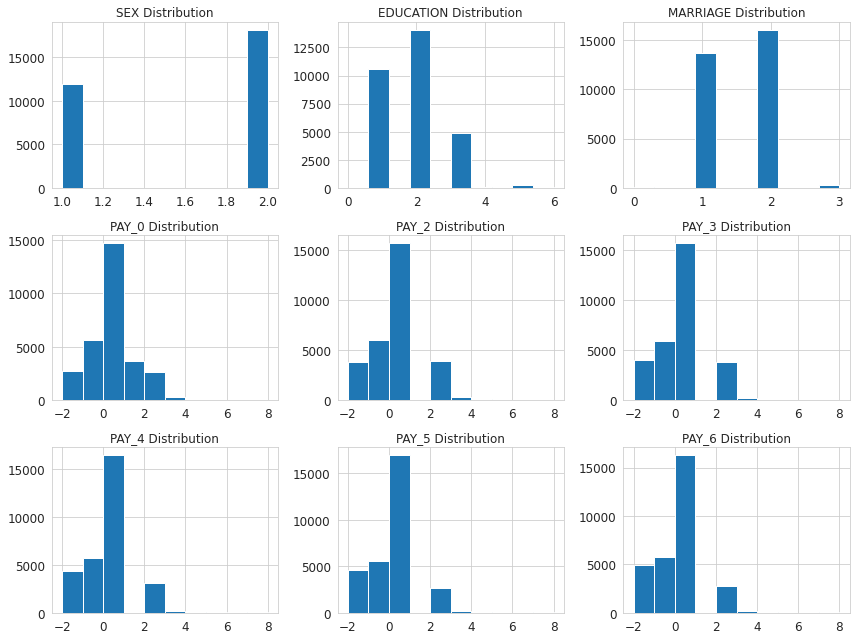

In [21]:
draw_hists(df,cat_vars,3,3)

For feature EDUCATION, values 1-4 were defined. Our min and max value is 0 and 6 respectively. We will treat those values as Unknown (=5).
<br> For feature MARRIAGE, values 1-3 were defined. We will treat the min value of 0 and higher as others (3)

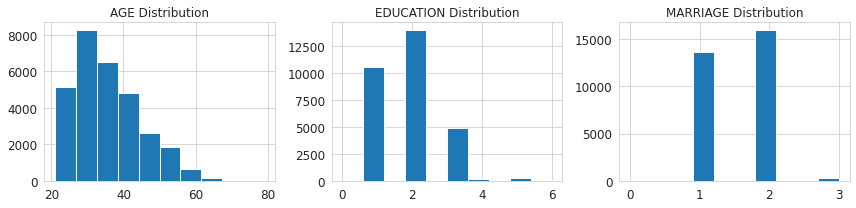

In [22]:
draw_hists(df,['AGE','EDUCATION','MARRIAGE'],1,3)

#### Visualization - pie plot, distribution, pairplot, hisplot, heatmap, etc

0    23364
1     6636
Name: default, dtype: int64


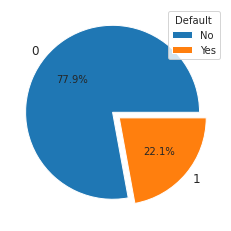

In [23]:
# check data balance
check_balance(df['default'])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


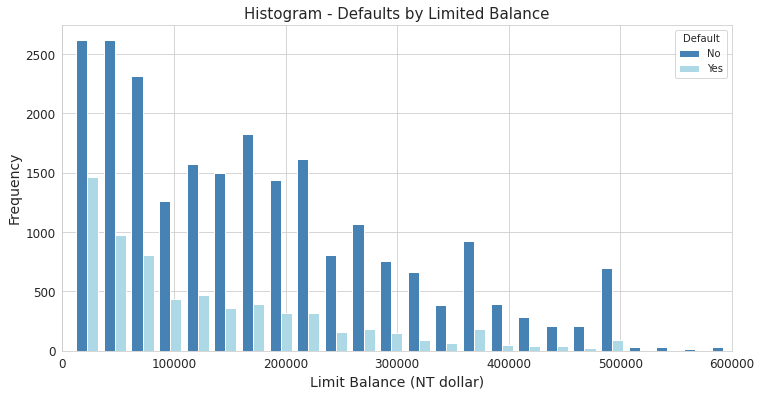

In [24]:
# Distribution of default
def0 = list(df[df['default']==0]['LIMIT_BAL'])
def1 = list(df[df['default']==1]['LIMIT_BAL'])
plt.figure(figsize=(12,6))
plt.hist([def0,def1], bins=40, color=['steelblue', 'lightblue']);
plt.xlim([0,600000])
plt.legend(['No', 'Yes'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('Histogram - Defaults by Limited Balance', SIZE=15);

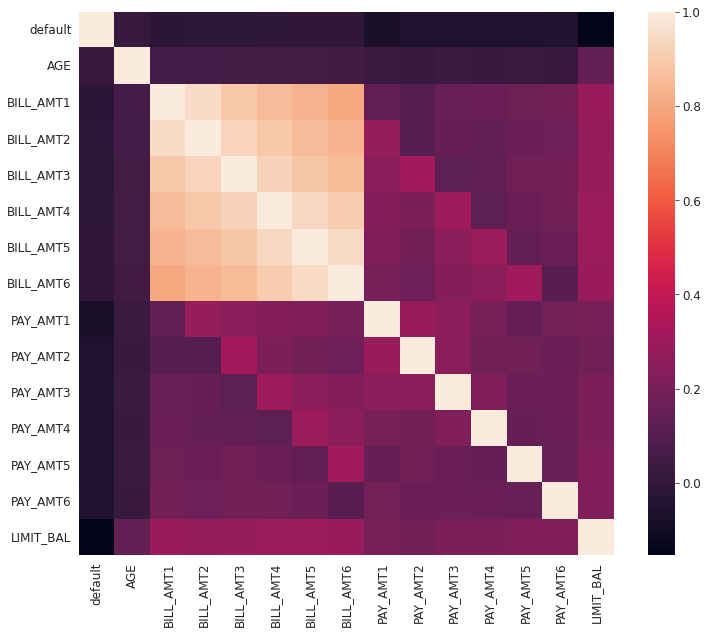

In [25]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(12,10))
sns.heatmap(df[dep_var+discrete_vars+continuous_vars1+continuous_vars2].corr())#,cmap=cmap);

High correlation between the Bill amounts in different months, week correlation between bill amount and payment amount. Default seems to have very weak (negative) correlation with predictor valiables, based on Pearson correlation analysis.

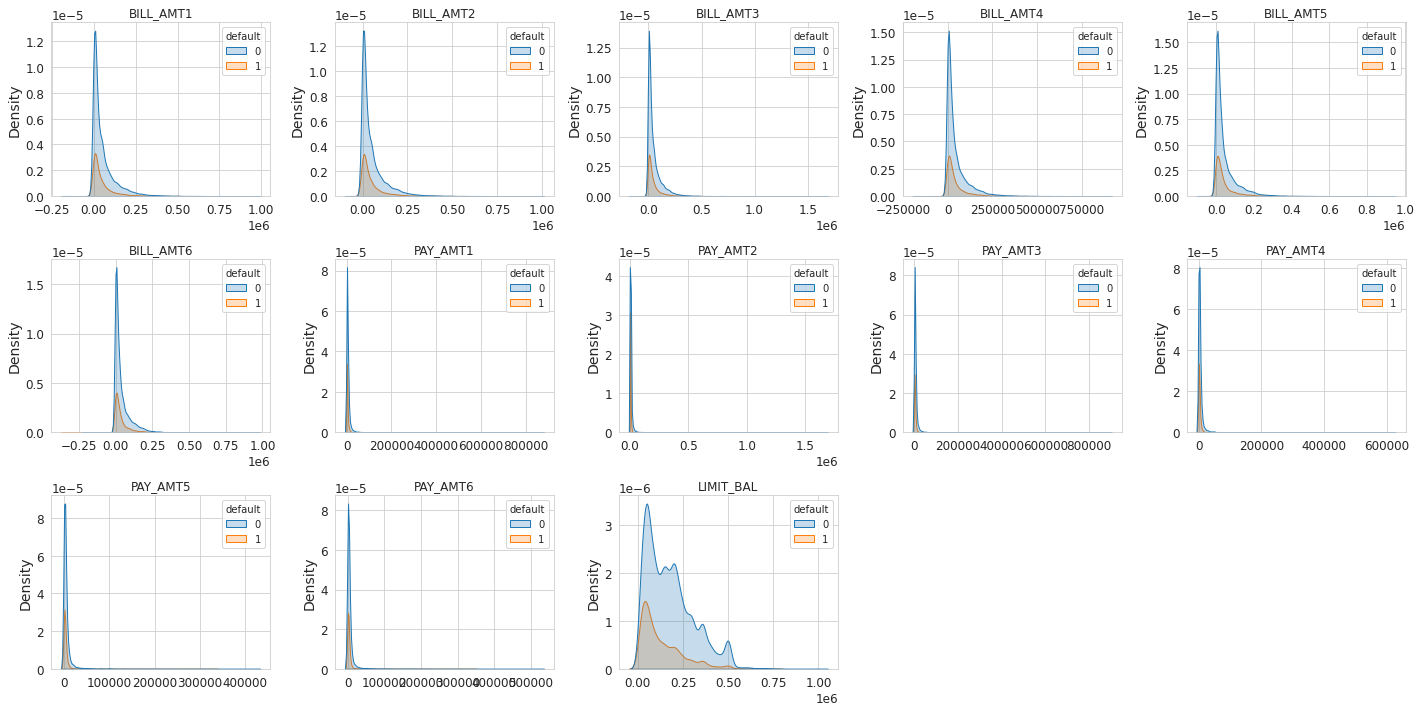

In [26]:
# Kernal density plots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = continuous_vars1 + continuous_vars2  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    data = df[[col, 'default']]  # select the data
    sns.kdeplot(data=data, x=col, hue='default', shade=True, ax=ax)
    ax.set(title=f'{col}', xlabel=None)
    
fig.delaxes(axes[14])  # delete the empty subplot
fig.delaxes(axes[13])  # delete the empty subplot
fig.tight_layout()
plt.show()

Kernal density plots indicate there is clearly difference in distribution of the variables between default and non-default populations.

<Figure size 1440x1440 with 0 Axes>

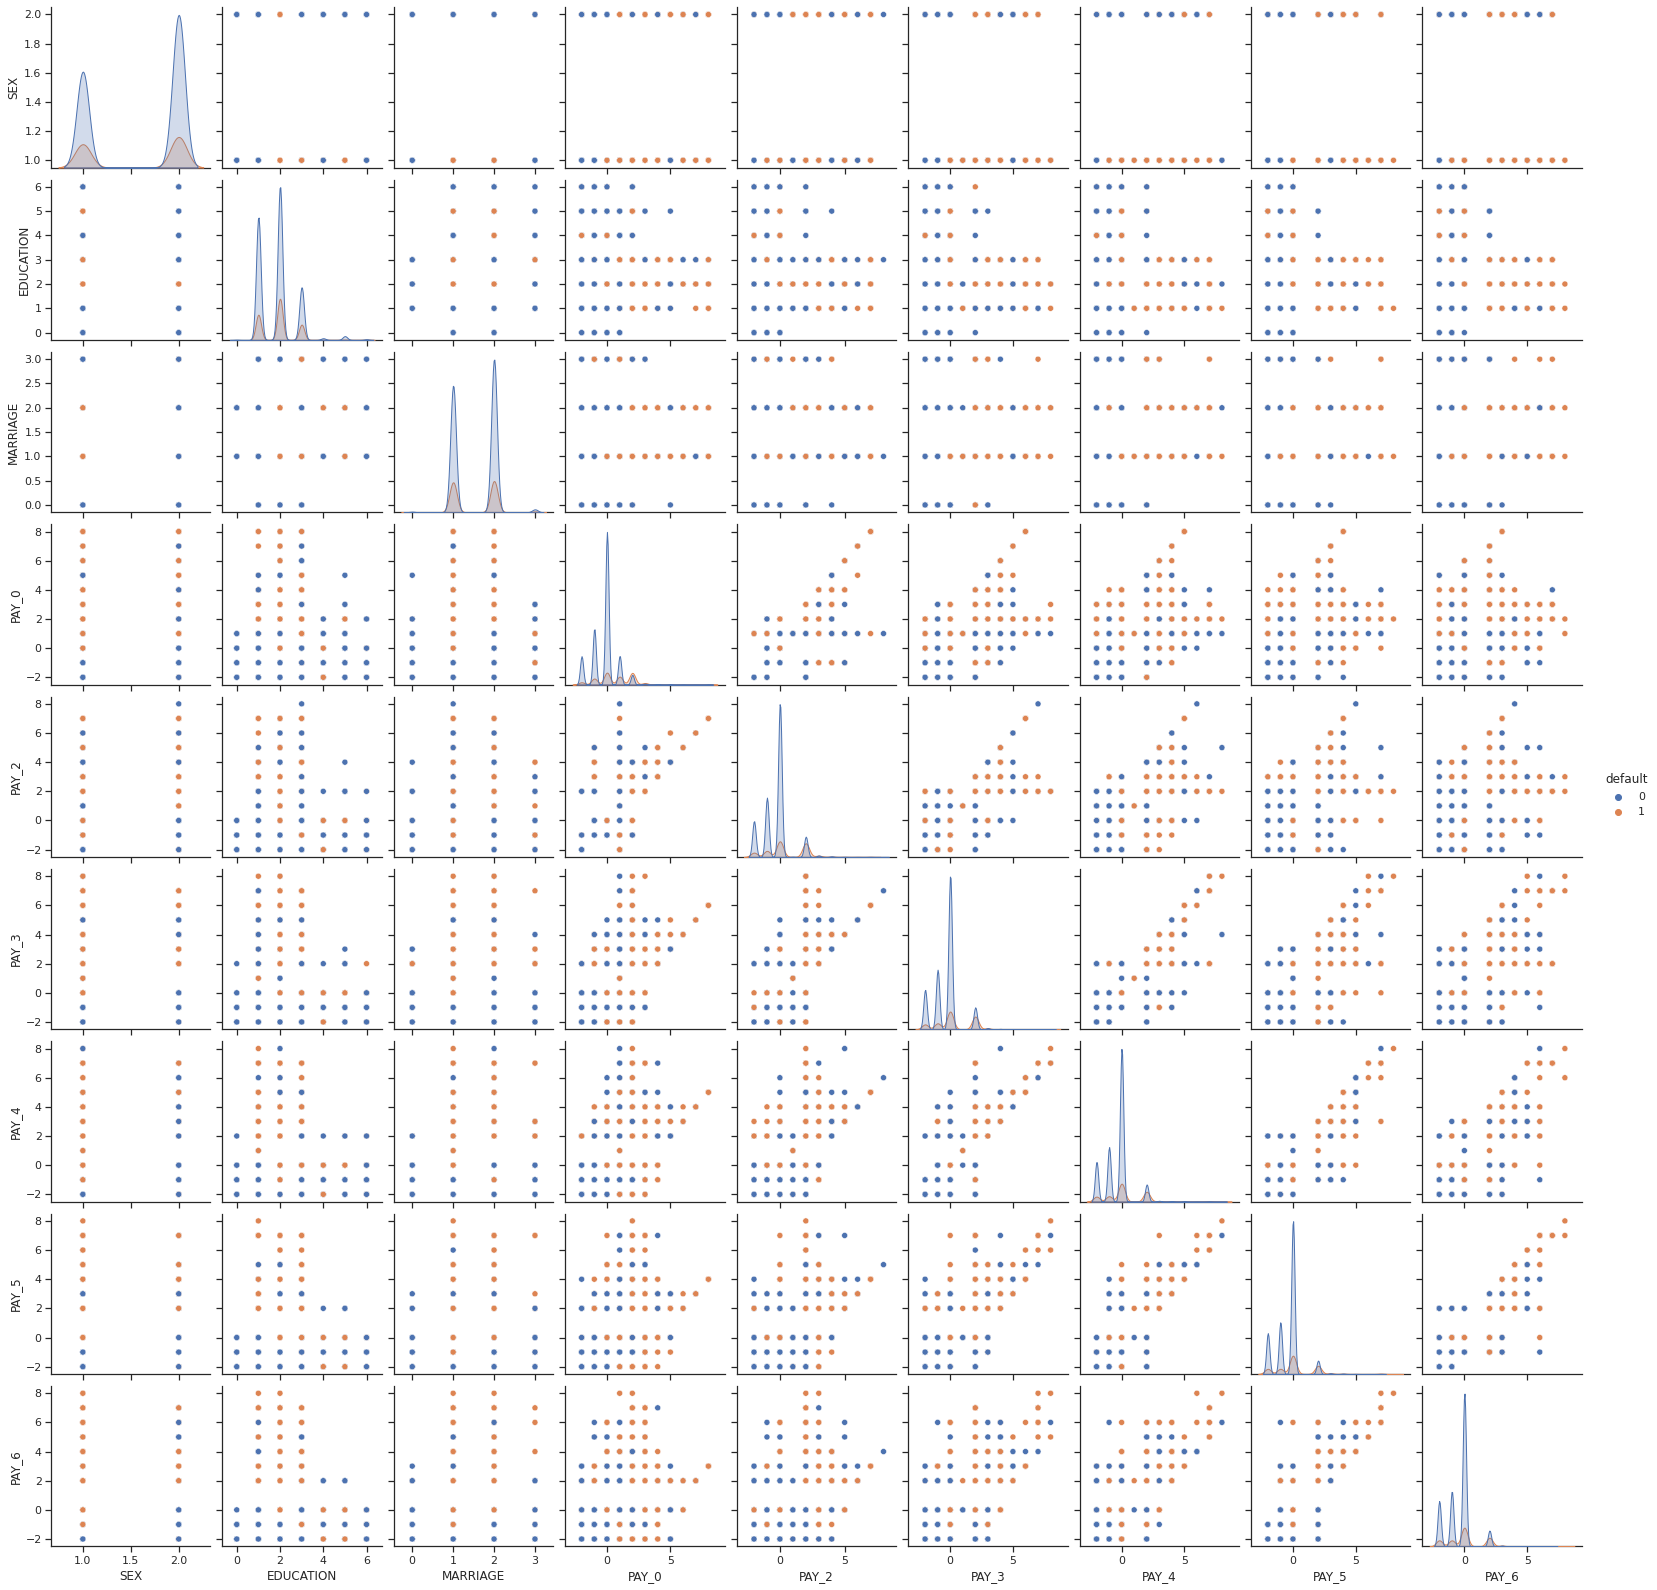

In [27]:
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(df.loc[:,dep_var+cat_vars], hue='default')

<Figure size 1440x1440 with 0 Axes>

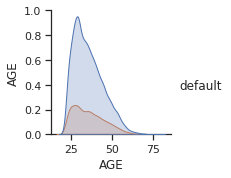

In [28]:
sns.set(style='ticks')
plt.figure(figsize=(20,20));
sns.pairplot(df.loc[:,dep_var+discrete_vars], hue='default');

<Figure size 1440x1440 with 0 Axes>

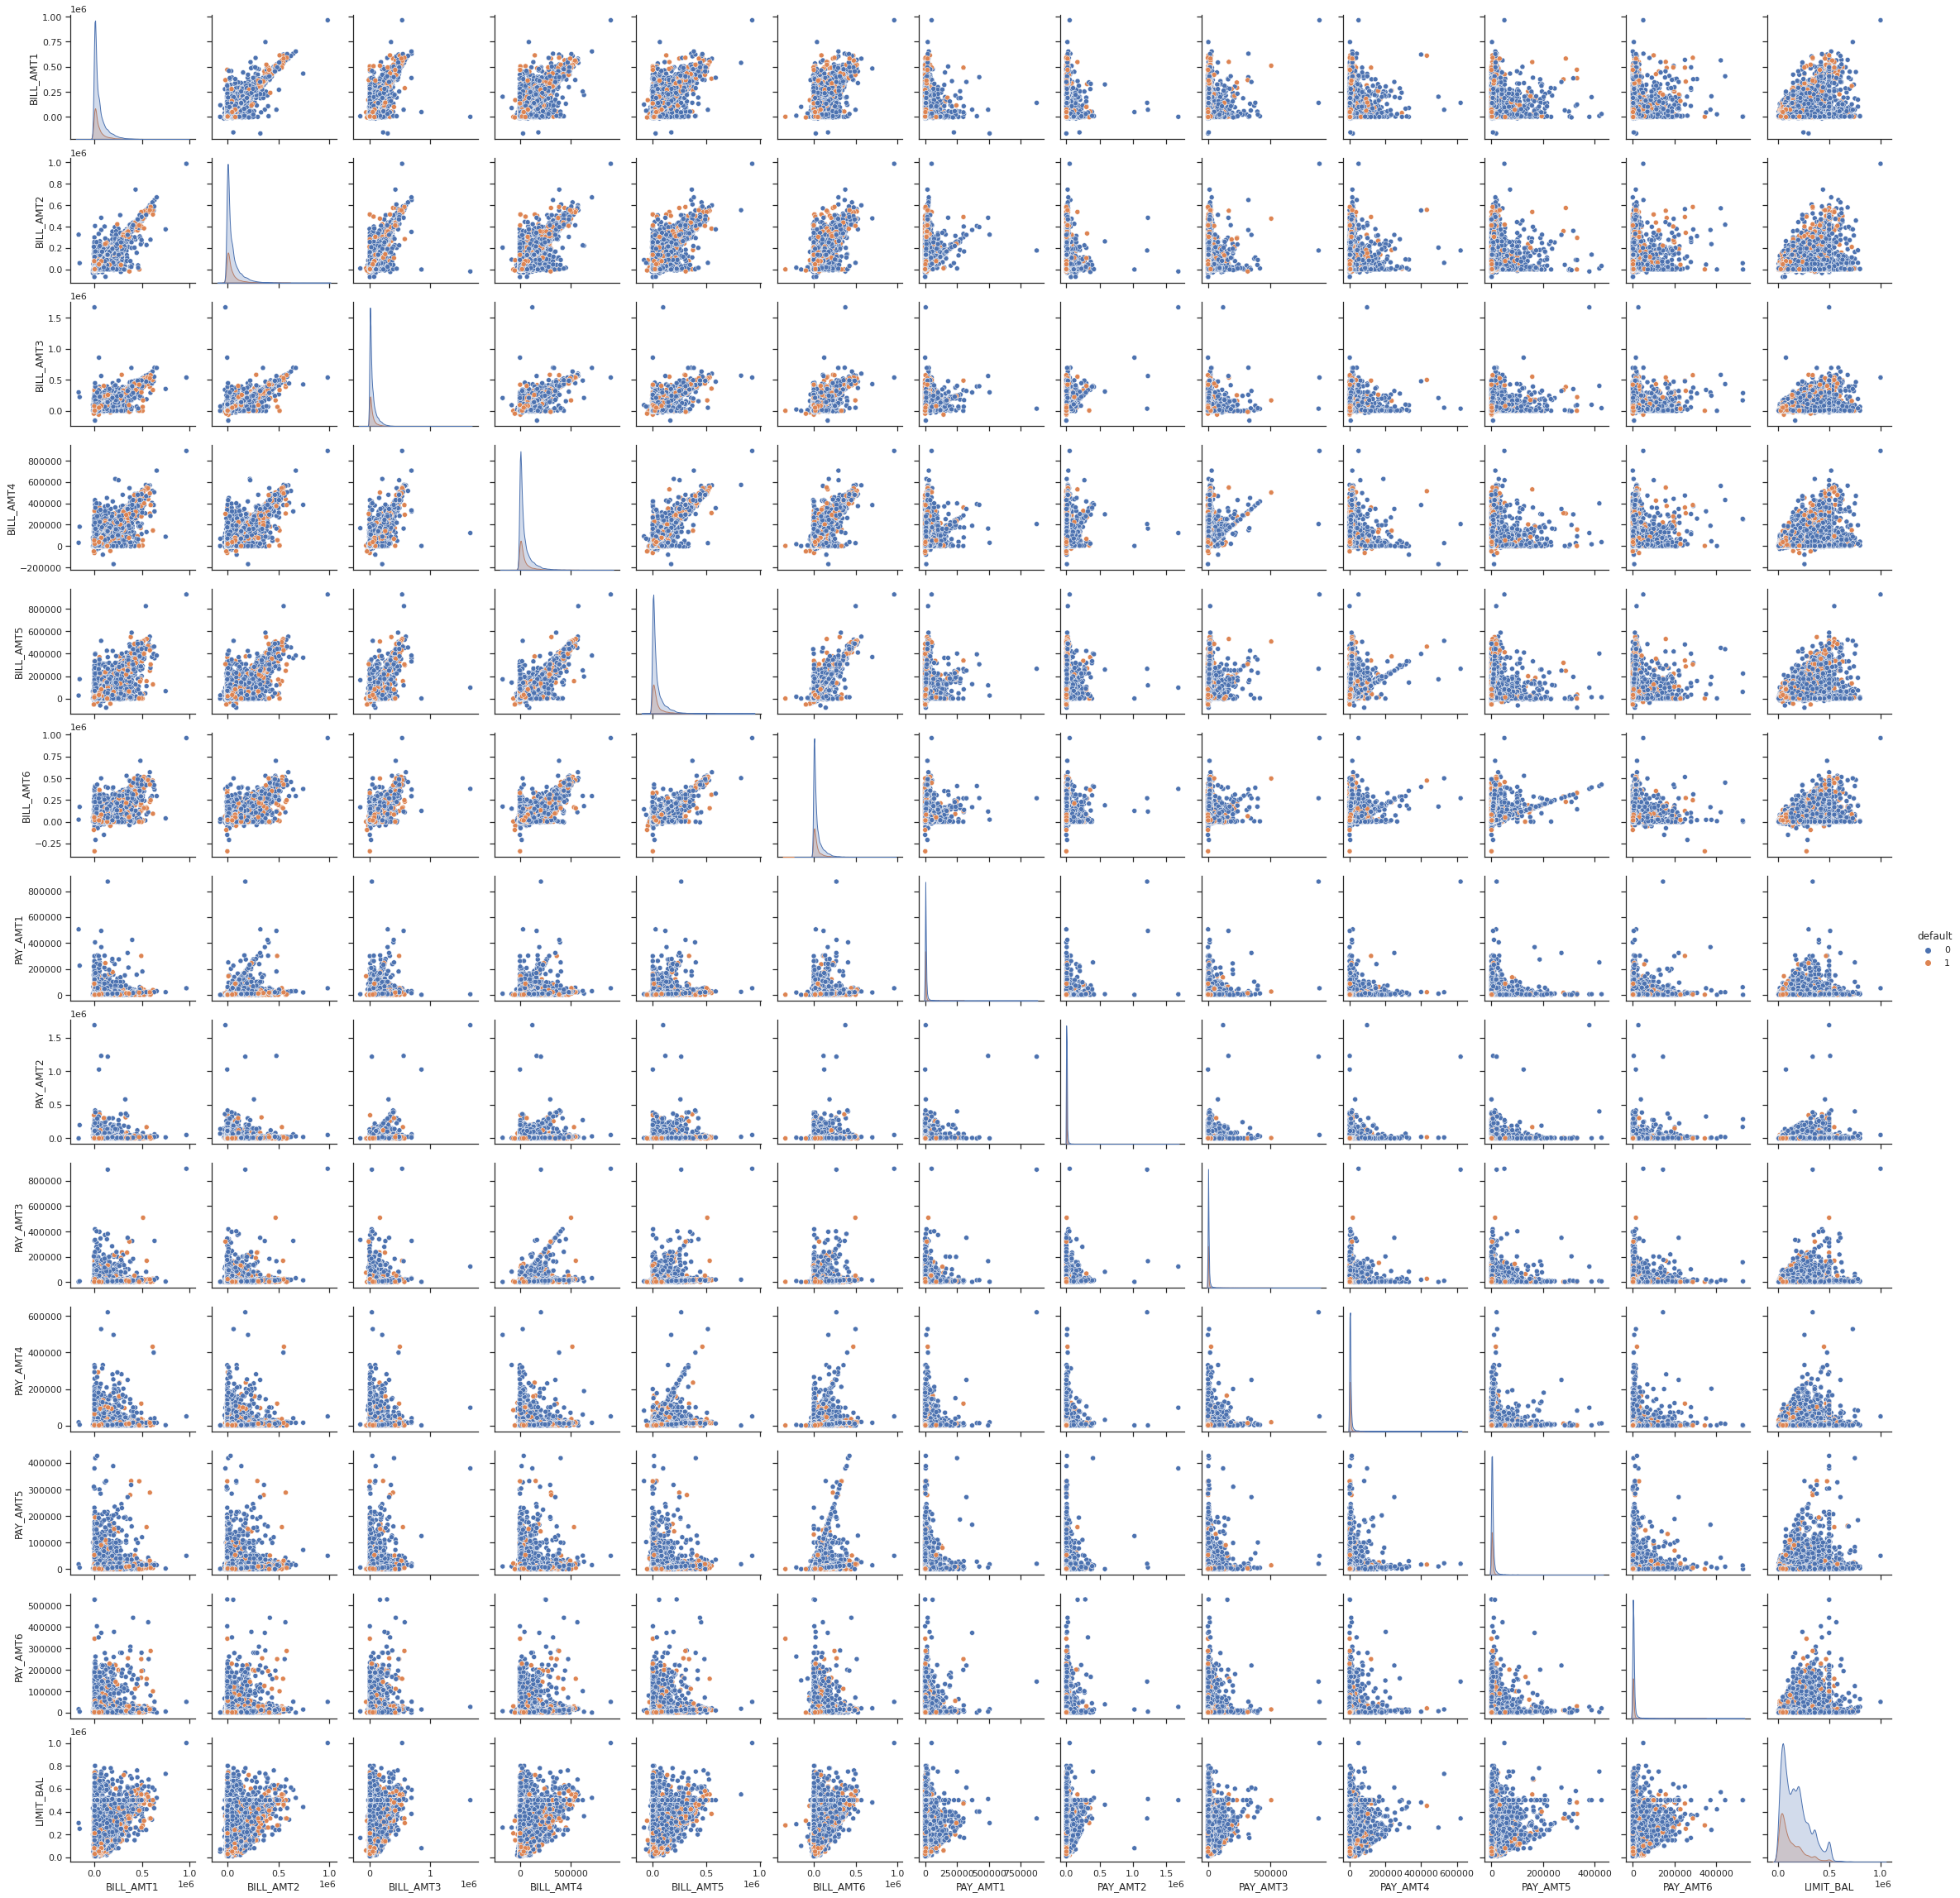

In [29]:
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(df.loc[:,dep_var+continuous_vars1+continuous_vars2], hue='default')

In [30]:
# Number of negative values and zeros
for feature in continuous_vars1:
  print(feature,"- Negative values: ",df[df[feature]<0].shape[0],"    Zeros:",df[df[feature]==0].shape[0])

BILL_AMT1 - Negative values:  590     Zeros: 2008
BILL_AMT2 - Negative values:  669     Zeros: 2506
BILL_AMT3 - Negative values:  655     Zeros: 2870
BILL_AMT4 - Negative values:  675     Zeros: 3195
BILL_AMT5 - Negative values:  655     Zeros: 3506
BILL_AMT6 - Negative values:  688     Zeros: 4020


Approximately 590-700 Negative values for the BILLAMT in different months. These values will have issues if performing log tranformation. These might also affect scaler selection.

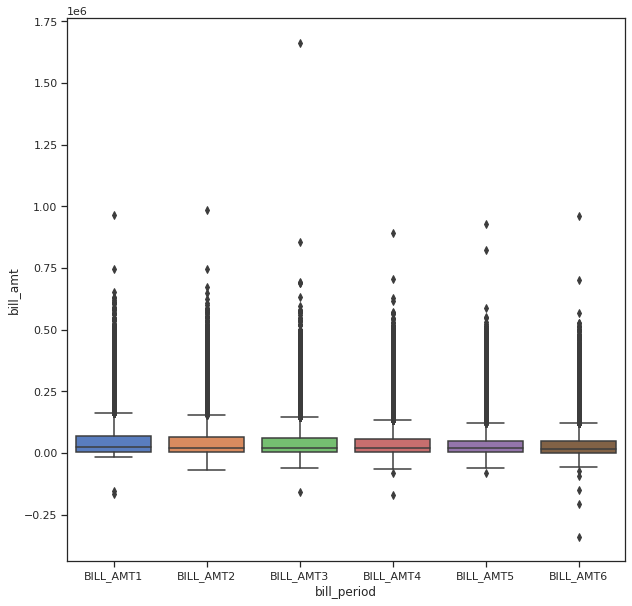

In [31]:
# Check outliers with boxplots
bill_amt = df[['default','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
bill_amt = pd.melt(bill_amt,id_vars="default",
                    var_name="bill_period",
                    value_name='bill_amt')

plt.figure(figsize=(10,10))
sns.boxplot(x='bill_period',y=bill_amt['bill_amt'], data=bill_amt, palette="muted");

BoxPlots indicates that the low negative values in the BILL_AMT varaibles are mostly outliers.

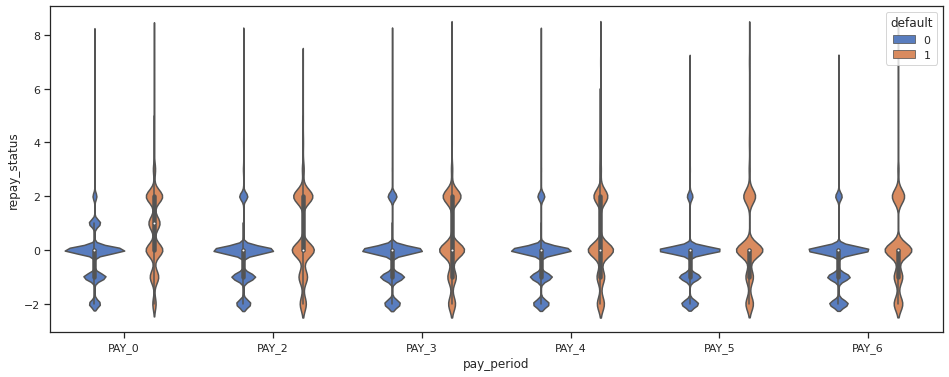

In [32]:
# PAY_x status
repay = df[['default','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
repay = pd.melt(repay,id_vars='default',
                    var_name='pay_period',
                    value_name='repay_status')
fig = plt.figure(figsize=(16,6))
sns.violinplot(x="pay_period", y="repay_status", hue='default',data=repay, palette="muted");

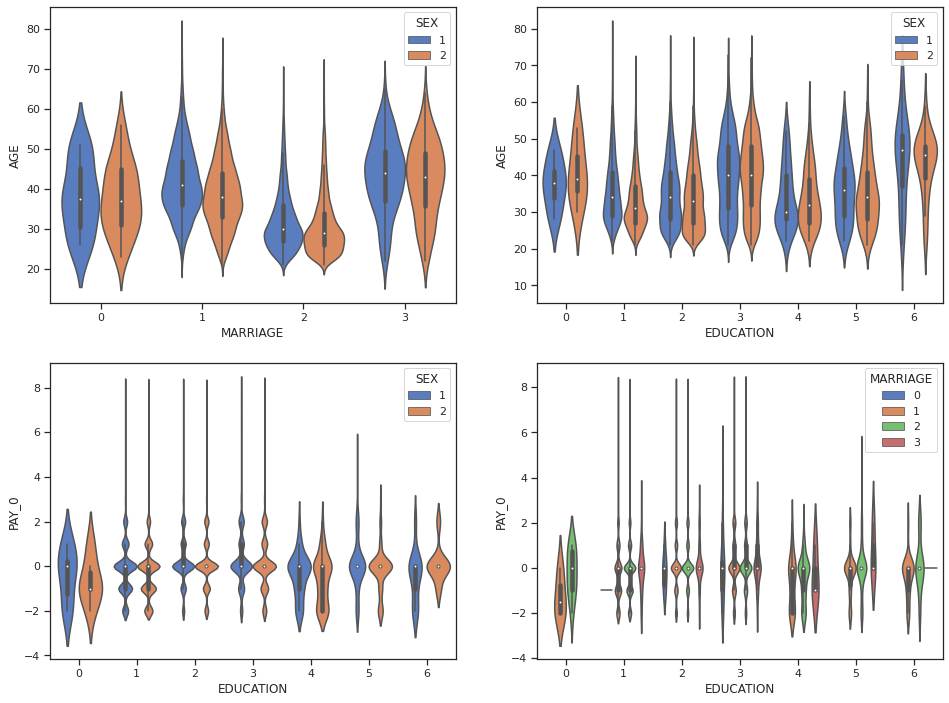

In [33]:
fig = plt.figure(figsize=(16,12))
ax=fig.add_subplot(2,2,1)
sns.violinplot(x="MARRIAGE", y="AGE", hue="SEX",data=df, palette="muted")
ax=fig.add_subplot(2,2,2)
sns.violinplot(x="EDUCATION", y="AGE", hue="SEX",data=df, palette="muted")
ax=fig.add_subplot(2,2,3)
sns.violinplot(x="EDUCATION", y="PAY_0", hue="SEX",data=df, palette="muted")
ax=fig.add_subplot(2,2,4)
sns.violinplot(x="EDUCATION", y="PAY_0", hue="MARRIAGE",data=df, palette="muted");


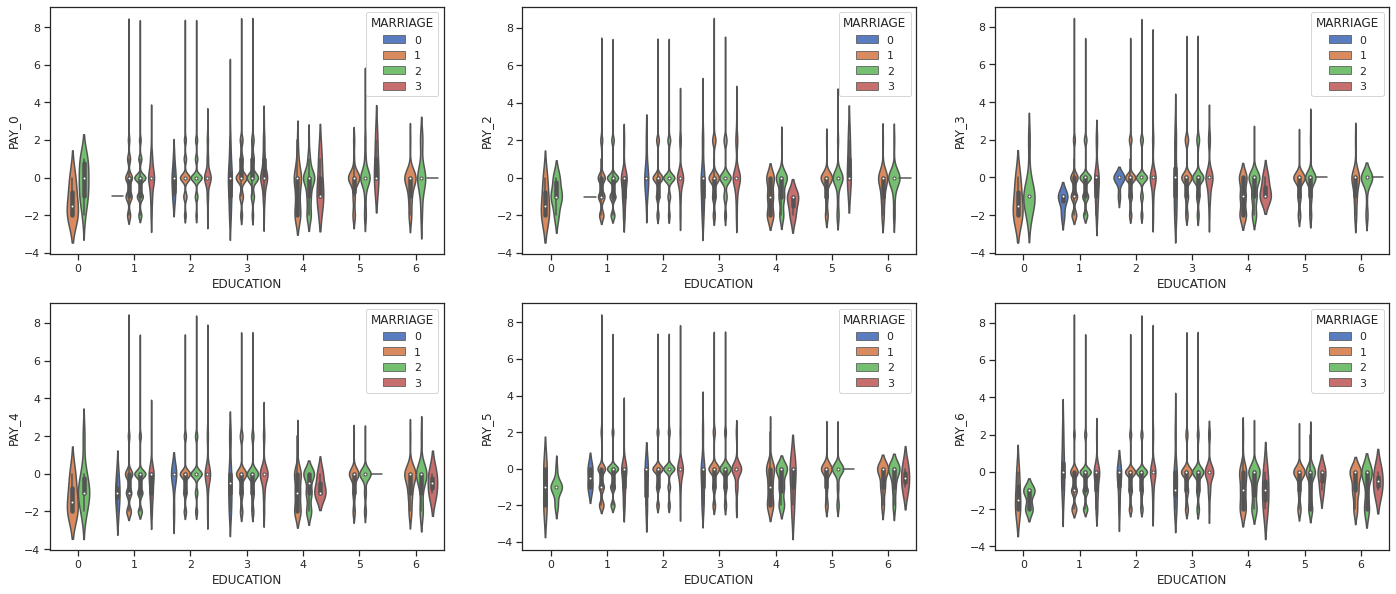

In [34]:
fig = plt.figure(figsize=(24,10))
ax=fig.add_subplot(2,3,1)
sns.violinplot(x="EDUCATION", y="PAY_0", hue="MARRIAGE",data=df, palette="muted")
ax=fig.add_subplot(2,3,2)
sns.violinplot(x="EDUCATION", y="PAY_2", hue="MARRIAGE",data=df, palette="muted")
ax=fig.add_subplot(2,3,3)
sns.violinplot(x="EDUCATION", y="PAY_3", hue="MARRIAGE",data=df, palette="muted")
ax=fig.add_subplot(2,3,4)
sns.violinplot(x="EDUCATION", y="PAY_4", hue="MARRIAGE",data=df, palette="muted")
ax=fig.add_subplot(2,3,5)
sns.violinplot(x="EDUCATION", y="PAY_5", hue="MARRIAGE",data=df, palette="muted")
ax=fig.add_subplot(2,3,6)
sns.violinplot(x="EDUCATION", y="PAY_6", hue="MARRIAGE",data=df, palette="muted");


The above violine plots indicate the un-defined values in Marriage and Education variables.

## 2 -  Data Processing

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Group features

In [36]:
df = df0.copy()

# Group variables
target = 'default payment next month'
predictor_vars = [col for col in df.columns if col not in [target]]
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numeric_vars = [col for col in predictor_vars if col not in cat_vars]

### Split data into train and test sets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df[predictor_vars],df[target],test_size=0.2,random_state=10086)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (24000, 23)
y_train shape: (24000,)
X_test shape: (6000, 23)
y_test shape: (6000,)


0    18690
1     5310
Name: default payment next month, dtype: int64


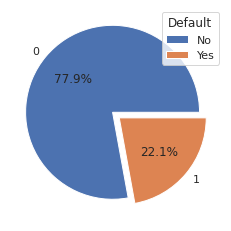

In [38]:
check_balance(y_train)

0    4674
1    1326
Name: default payment next month, dtype: int64


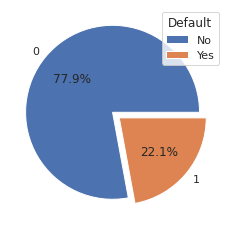

In [39]:
check_balance(y_test)

### Define custom pipelines

In [43]:
# non-defined values in a column as others
class colImputer(BaseEstimator, TransformerMixin):
  def __init__(self,column=[], valid_values=[], replace=None):
     self.column = column
     self.valid_values = valid_values
     self.replace = replace
  def fit(self,X, y=None):
   return self
  def transform(self, X, y=None):
    if len(self.column) >= 1:
      X.loc[:,self.column] = [x if x in self.valid_values else self.replace for x in X.loc[:,self.column]]
    return X

### Build Pipelines

In [44]:
# Categorical - replace_invalid, impute, one hot encode
cat_edu_step = ('edu', colImputer(column='EDUCATION', valid_values=[1,2,3,4], replace=4))
cat_marriage_step = ('marriage', colImputer(column='MARRIAGE', valid_values=[1,2,3], replace=3))
# New dataset might have missing values. fill missing value to a new category
cat_si_step = ('si', SimpleImputer(strategy='constant',fill_value=20))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_edu_step, cat_marriage_step, cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_vars)]

# Numerical - impute, scale
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', RobustScaler()) # considering outliers
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, numeric_vars)]

In [45]:
# full pipeline
pipeline_full = ColumnTransformer(transformers=cat_transformers + num_transformers)

### Apply pipeline and train the models

In [46]:
# Apply pipeline fittting on train set
pipeline_full.fit(X_train, y_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (24000, 87)
X_test_transformed.shape: (6000, 87)


## 3 - Classification

### a. Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

We will tune only n_estimators. Grid Search with 5 fold cross validation, using roc_auc scoring

In [48]:
param_grid={'n_estimators': [4, 5, 10, 20, 50]}

In [49]:
%%time
rfc = RandomForestClassifier(random_state=10086)
rfc_CV = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5,scoring='roc_auc')
rfc_CV.fit(X_train_transformed,y_train)

CPU times: user 25.6 s, sys: 3.19 ms, total: 25.6 s
Wall time: 25.5 s


In [50]:
print("Best Estimator: ",{rfc_CV.best_estimator_})
print("Best Score:", rfc_CV.best_score_)
print("Scorer:",rfc_CV.scorer_)

Best Estimator:  {RandomForestClassifier(n_estimators=50, random_state=10086)}
Best Score: 0.7607476378900868
Scorer: make_scorer(roc_auc_score, needs_threshold=True)


In [51]:
# results
rfc_CV.cv_results_

{'mean_fit_time': array([0.21896448, 0.25559578, 0.49482718, 0.96872673, 2.3898077 ]),
 'mean_score_time': array([0.01052713, 0.01265564, 0.01889591, 0.03439851, 0.07709188]),
 'mean_test_score': array([0.69248762, 0.7017924 , 0.72850845, 0.74769308, 0.76074764]),
 'param_n_estimators': masked_array(data=[4, 5, 10, 20, 50],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 4},
  {'n_estimators': 5},
  {'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 50}],
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.6982113 , 0.70615045, 0.73604965, 0.76263012, 0.77817755]),
 'split1_test_score': array([0.68824835, 0.6927291 , 0.72345681, 0.73951522, 0.74991826]),
 'split2_test_score': array([0.69311955, 0.70467203, 0.72344245, 0.7477389 , 0.75971659]),
 'split3_test_score': array([0.70156214, 0.7144759 , 0.73985605, 0.75252812, 0.76781117]),
 'split4_test_sc

#### Random Forest Classifier Performance

In [52]:
# Performance 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = rfc_CV.predict(X_test_transformed)
y_pred_proba = rfc_CV.predict_proba(X_test_transformed) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()

print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"precision_score: {precision_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

accuracy_score: 0.8148333333333333
precision_score: 0.6405228758169934
recall_score: 0.3695324283559578
f1_score: 0.468675274988044
roc_auc_score: 0.7644056108339126


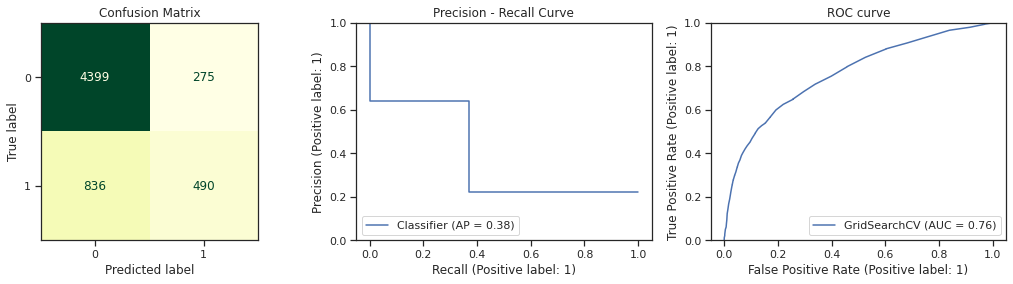

In [53]:
# plotting the performence curves
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve

fig = plt.figure(figsize=(18,4));
ax = fig.add_subplot(1,3,1) 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='YlGn',colorbar=False,ax=ax);
plt.title('Confusion Matrix')
plt.grid(False)

ax = fig.add_subplot(1,3,2)
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax);
plt.title('Precision - Recall Curve')
plt.ylim(0,1);
plt.grid(False);

ax = fig.add_subplot(1,3,3)
RocCurveDisplay.from_estimator(rfc_CV, X_test_transformed, y_test, ax=ax);
plt.title('ROC curve')
plt.ylim(0,1);
# plt.grid(False);

### b. KNN Classifier

Tune only n_neighbors with grid search cross validation of 5 folds

In [54]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 10, 20]}

In [55]:
%%time
knn = KNeighborsClassifier()
knn_CV = GridSearchCV(estimator=knn,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=5)
knn_CV.fit(X_train_transformed,y_train)

CPU times: user 49.8 s, sys: 2.99 s, total: 52.8 s
Wall time: 39.7 s


It seems KNN classifier takes longer (41.4 sec) to tune the hyper parameters as compared to the Random Forest classifier (24.6 sec)

In [56]:
print("Best Estimator: ",knn_CV.best_estimator_)
print("Best Score:", knn_CV.best_score_)
print("Scorer:",knn_CV.scorer_)

Best Estimator:  KNeighborsClassifier(n_neighbors=20)
Best Score: 0.7352703037667807
Scorer: make_scorer(roc_auc_score, needs_threshold=True)


In [57]:
# Results
knn_CV.cv_results_

{'mean_fit_time': array([0.00946259, 0.00795112, 0.00829134, 0.00796022]),
 'mean_score_time': array([1.67794924, 2.06201768, 2.06247954, 2.08265905]),
 'mean_test_score': array([0.67221406, 0.69750647, 0.72205355, 0.7352703 ]),
 'param_n_neighbors': masked_array(data=[3, 5, 10, 20],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 20}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.67731316, 0.71008218, 0.73830344, 0.75448655]),
 'split1_test_score': array([0.65974282, 0.68051903, 0.70183382, 0.71543264]),
 'split2_test_score': array([0.67033339, 0.69537448, 0.72956348, 0.74424033]),
 'split3_test_score': array([0.68091994, 0.70488766, 0.72414904, 0.74034009]),
 'split4_test_score': array([0.672761  , 0.69666901, 0.71641796, 0.72185192]),
 'std_fit_time': array([0.00280177, 0.00015996, 0.00073047, 0.00

#### KNN Classifier Performance

In [59]:
# Performance 
y_pred_knn = knn_CV.predict(X_test_transformed)
y_pred_proba_knn = knn_CV.predict_proba(X_test_transformed) #to calculate ROC_AUC

print(f"accuracy_score: {accuracy_score(y_test, y_pred_knn)}")
print(f"precision_score: {precision_score(y_test, y_pred_knn)}")
print(f"recall_score: {recall_score(y_test, y_pred_knn)}")
print(f"f1_score: {f1_score(y_test, y_pred_knn)}")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba_knn[:,1])}")

accuracy_score: 0.8078333333333333
precision_score: 0.6575591985428051
recall_score: 0.2722473604826546
f1_score: 0.38506666666666667
roc_auc_score: 0.734191777497675


### Compare Performance

#### Compare by scores

In [60]:
## Print comparison
print(f"                 Random Forest    KNN Classifier")
print(f"accuracy_score:  {round(accuracy_score(y_test, y_pred),5)}          {round(accuracy_score(y_test, y_pred_knn),5)}")
print(f"precision_score: {round(precision_score(y_test, y_pred),5)}          {round(precision_score(y_test, y_pred_knn),5)}")
print(f"recall_score:    {round(recall_score(y_test, y_pred),5)}          {round(recall_score(y_test, y_pred_knn),5)}")
print(f"f1_score:        {round(f1_score(y_test, y_pred),5)}          {round(f1_score(y_test, y_pred_knn),5)}")
print(f"roc_auc_score:   {round(roc_auc_score(y_test, y_pred_proba[:,1]),5)}          {round(roc_auc_score(y_test, y_pred_proba_knn[:,1]),5)}")

                 Random Forest    KNN Classifier
accuracy_score:  0.81483          0.80783
precision_score: 0.64052          0.65756
recall_score:    0.36953          0.27225
f1_score:        0.46868          0.38507
roc_auc_score:   0.76441          0.73419


Random Forest classifier has higher scores than the KNN classifier, except for the Precision score, which indicates KNN has a higher percentage of true defaults for all predicted defaults.

#### Compare by graphs

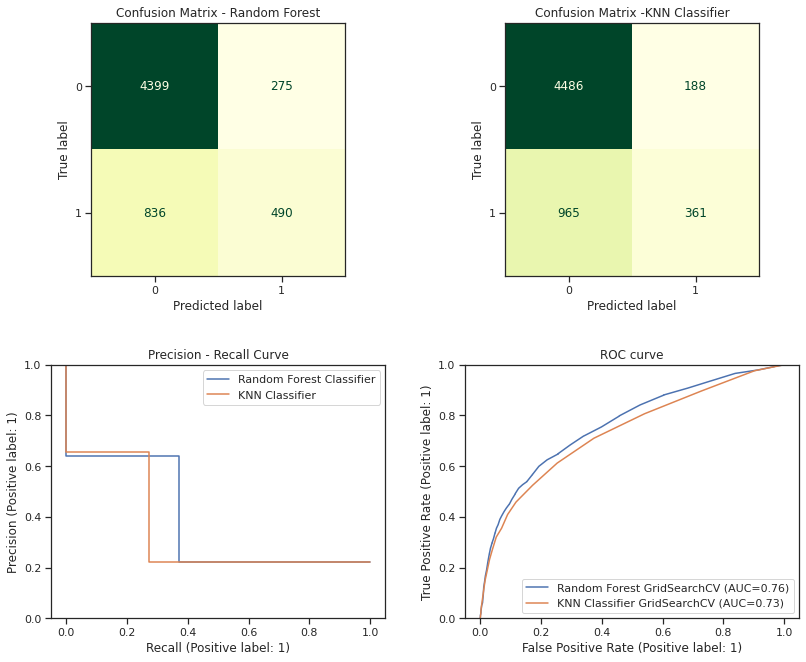

In [61]:
fig = plt.figure(figsize=(12,10));
ax = fig.add_subplot(2,2,1) 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='YlGn',colorbar=False,ax=ax)
plt.title('Confusion Matrix - Random Forest')
plt.grid(False)

ax = fig.add_subplot(2,2,2) 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='YlGn',colorbar=False,ax=ax);
plt.title('Confusion Matrix -KNN Classifier')
plt.grid(False)

ax = fig.add_subplot(2,2,3)
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax);
PrecisionRecallDisplay.from_predictions(y_test, y_pred_knn, ax=ax);
plt.title('Precision - Recall Curve')
plt.legend(['Random Forest Classifier','KNN Classifier'], loc='upper right')
plt.ylim(0,1);
plt.grid(False);

ax = fig.add_subplot(2,2,4)
RocCurveDisplay.from_estimator(rfc_CV, X_test_transformed, y_test, ax=ax);
RocCurveDisplay.from_estimator(knn_CV, X_test_transformed, y_test, ax=ax);
plt.legend(['Random Forest GridSearchCV (AUC={})'.format(round(roc_auc_score(y_test, y_pred_proba[:,1]),2)),
            'KNN Classifier GridSearchCV (AUC={})'.format(round(roc_auc_score(y_test, y_pred_proba_knn[:,1]),2))], loc='lower right')
plt.title('ROC curve')
plt.ylim(0,1);
# plt.grid(False);
plt.tight_layout(pad=3.0)

From the plots above, it is clear the **Random Forest Classifier performs better than KNN classifier** in terms of ROC_AUC_Sscore, Precision-Recall curve. <br>
For KNN classifier, the best estimator can identify 361 defaults out of 1326 true defaults (***Recall=0.27***), with a false positive rate of 34% (Precision=0.66). <br>
For Random Forest classifier, the best estimator can identify 490 defaults out of 1326 true defaults (***recall=0.37***), with a false positive rate of 36% (precision=0.64). <br>
ROC curve confirms **Random Forest classifier** performs better with a ***higher AUC score of 0.76***, compared to 0.73 for KNN classifier. <br>
**Precion-Recal curve** indicates there is ***large room for improvement*** of the models. <br>
It seems that a threshold somewhere between 0.2-0.4 would give a somewhat balanced precision and recall, although both scores are low.

#### **Learning curves**

In [85]:
# Push the modified plot_learning_curve.py to GitHub repository
# and download from there
import requests
# Save plot_learning_curve as file to colab working directory
# Get the "Raw" version of the code from GitHub
url = 'https://raw.githubusercontent.com/TessieTong/ds4ml/main/plot_learning_curve.py'
r = requests.get(url)

# Write to Colab working directory 
with open('plot_learning_curve.py', 'w') as f:
    f.write(r.text)

# import
import plot_learning_curve

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


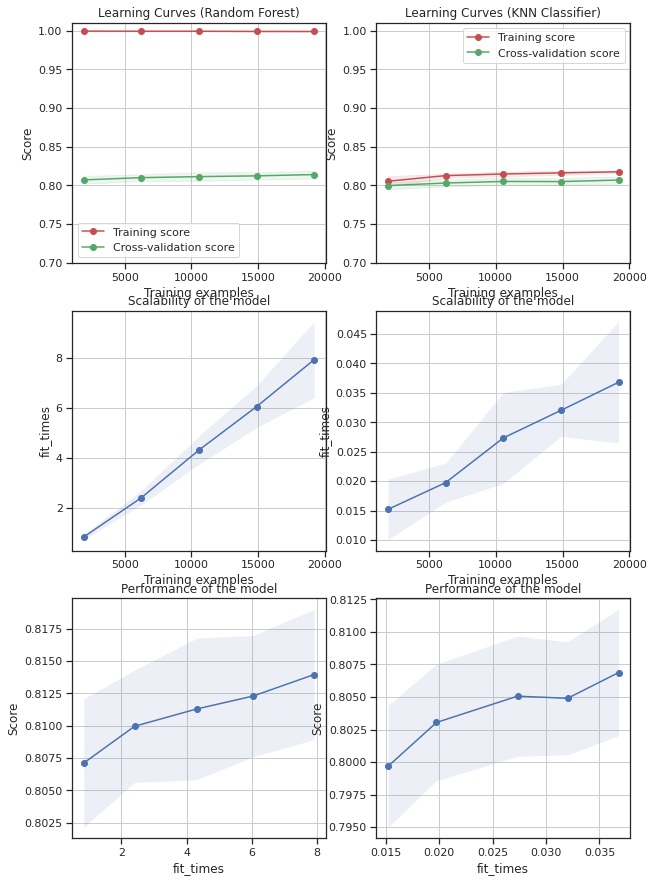

In [68]:
# Plot learning curves of two classifiers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# from plot_learning_curve import plot_learning_curve

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (Random Forest)"
# Cross validation with 10 iterations
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=10086)

estimator = RandomForestClassifier(n_estimators=50)
plot_learning_curve(
    estimator, title, X_train_transformed, y_train, 
    axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (KNN Classifier)"
estimator = KNeighborsClassifier(n_neighbors=20)
plot_learning_curve(
    estimator, title, X_train_transformed, y_train, 
    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show();

It seems the for Random Forest Classifier, the training score remains high, while cross-validation score increases slowly with more training sample. Therefore, more training examples may not improve the performance. This indicates that the current Random Forest Classifier is overfitting. <br>
On the other hand, the learning curves of the training and cross validation remain low and similar with increasing training examples, 

## Conclusions

#### -- Based on the above analysis, the preliminary Random Forest and KNN models, using raw features (without engineering new features) and tuning only with n_estimators (Random Forest) and n_neighbors (KNN), can predict credit card defaults at a certain level of success. <br> 
#### -- With the given set of hyperparameters, grid search indicates **Random Forest classifier has a *better* performance than KNN classifier** in terms of ROC AUC score. <br>
#### -- Learning curves of the classifiers indicate Random Forest classifier at the best estimator (n_estimators=50) may be overfitting.
#### -- The performance of the classifiers may be further improved by, for example, engineering new features (by tranform data and across-featuring) and using more parameters in the gridsearch, and/or more values in each parameter for hyperparameter tuning. <br>
#### -- The next step would be to try put feature engineering and expanding parameter search grid. And perhaps try other classifiers.

# -- THE END --